In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

C:\Users\penthotal\Desktop\git_repositories\bayesian_ANN


In [24]:
from tensorflow.keras.datasets.imdb import load_data as load_imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import StratifiedShuffleSplit

import pymc3 as pm

from modules.neural_networks import BayesianWordEmbedding

from modules.viz_utils import visulize_categorical_post, visulize_bernoulli_post, visualize_embedding

# Sentiment Classification With Words Embedding

In [21]:
(X_tr, y_tr), (X_ts, y_ts) = load_imdb(
    skip_top=100,
    num_words=4000,
    maxlen=90
)
X_tr = pad_sequences(X_tr, padding='post', value=2)
X_tr = X_tr[:, :20]
X_ts = pad_sequences(X_ts, padding='post', value=2)
X_ts = X_ts[:, :20]

mapper = {2: 0}
code = 1
for element in np.unique(X_tr):
    if element == 2:
        continue
    mapper[element] = code
    code += 1

def mapper_func(x, mapper=mapper):
    try:
        return mapper[x]
    except:
        return 0
    
X_tr = np.vectorize(mapper_func)(X_tr)
X_ts = np.vectorize(mapper_func)(X_ts)

C:\Users\penthotal\miniconda3\envs\pr_test_env\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


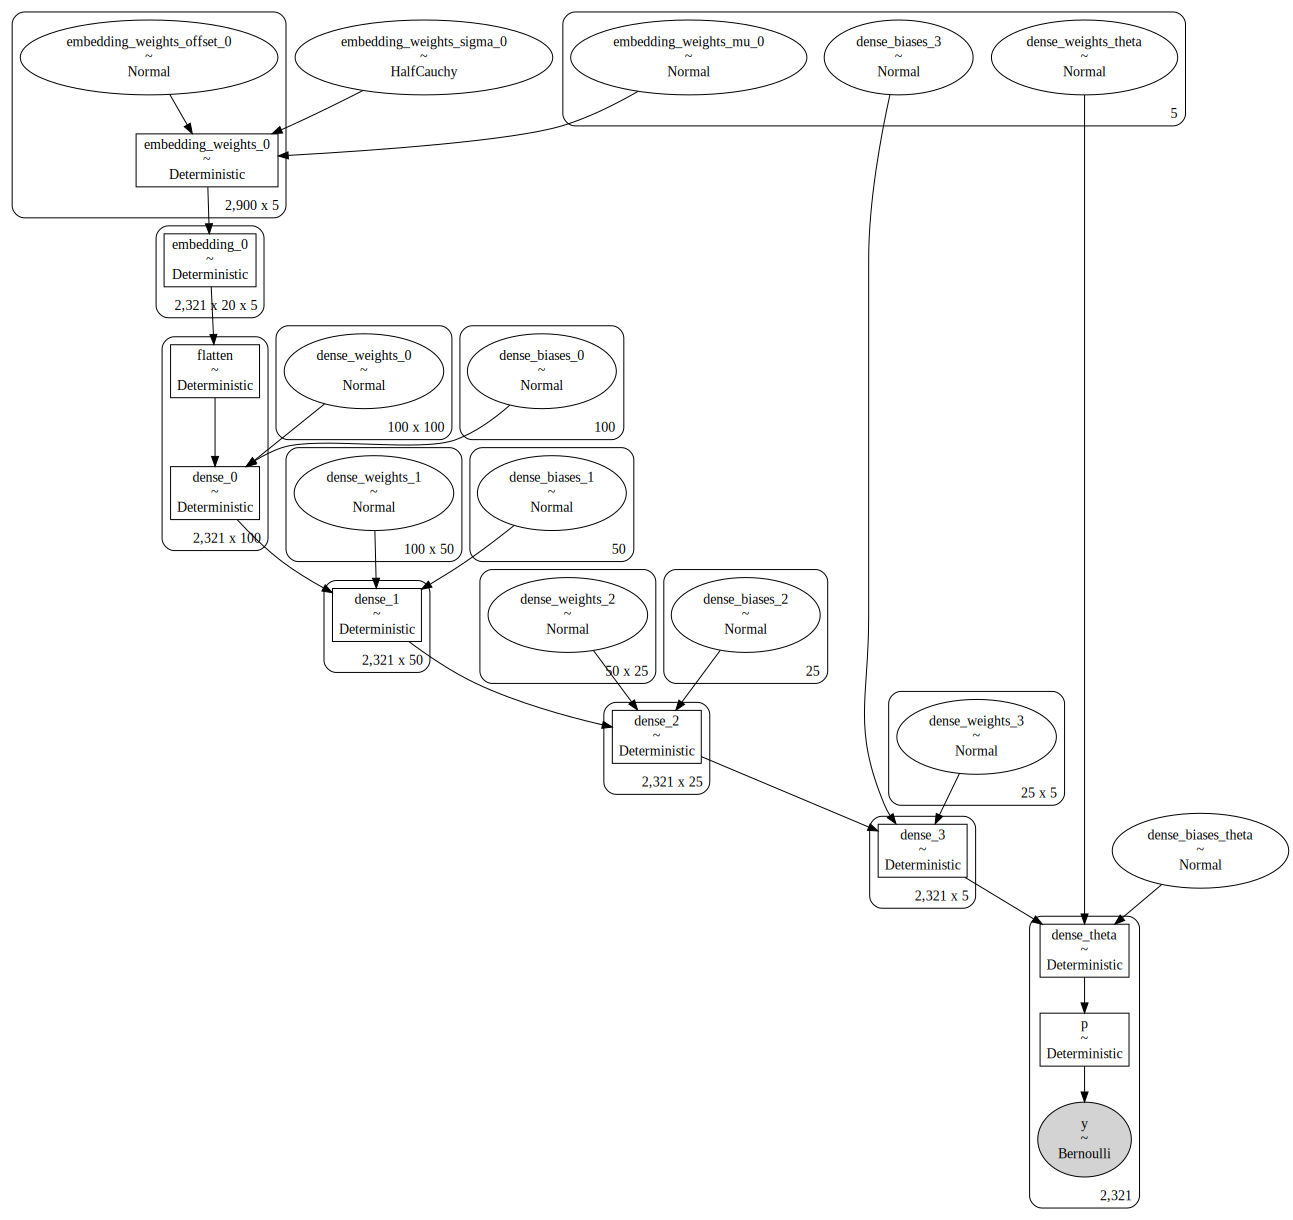

In [30]:
embedding_model = BayesianWordEmbedding(
    X=X_tr, 
    y=y_tr, 
    shape_out=1, 
    likelyhood_model='bernoulli_lk',
    vocabulary_size=int(X_tr.max()+1), 
    embedding_size=25, 
    prior=pm.Normal,
    layers=(50, 25, 5),
    activation='tanh', 
    batch_size=32,
)
embedding_model.show_graph()

In [31]:
embedding_model.fit(n=100000)
embedding_trace = embedding_model.predict(
    X_ts, 
    y_ts, 
    ['embedding_weights_0', 'p']
)

C:\Users\penthotal\miniconda3\envs\pr_test_env\lib\site-packages\theano\gpuarray\dnn.py:192: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn(


Interrupted at 29,058 [29%]: Average Loss = 527.35


array([[<AxesSubplot:title={'center':'embedding_weights_0'}>,
        <AxesSubplot:title={'center':'embedding_weights_0'}>]],
      dtype=object)

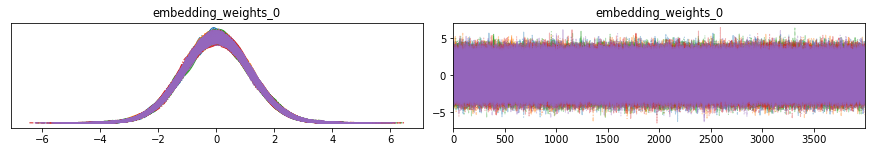

In [41]:
pm.plot_trace(embedding_trace, var_names=['embedding_weights_0'])

In [33]:
embedding_trace['p'].mean(0).max()

0.5783993320663189